In [25]:
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 12, 4

In [26]:
#评估方法
def gini(actual, pred, cmpcol = 0, sortcol = 1):
     assert( len(actual) == len(pred) )
     all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
     all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
     totalLosses = all[:,0].sum()
     giniSum = all[:,0].cumsum().sum() / totalLosses
 
     giniSum -= (len(actual) + 1) / 2.
     return giniSum / len(actual)

def gini_normalized(a, p):
        return gini(a, p) / gini(a, a)
    


#模型训练
def xgboostModelFit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #模型训练
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')
        
    #模型预测-训练集
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #输出模型效果-训练集:
    print "\nModel Report- train data"
    print "Accuracy（Train） : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob)
    print "GINI Score (Train): %f" % gini_normalized(dtrain['target'], dtrain_predprob)
    
    #模型预测-测试集
    dtest['prediction'] = alg.predict(dtest[predictors])
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    #输出模型效果-测试集
    print "\nModel Report- test data"
    print "Accuracy（Test） : %.4g" % metrics.accuracy_score(dtest['target'].values,dtest['prediction'])
    print 'AUC Score (Test): %f' % metrics.roc_auc_score(dtest['target'], dtest['predprob'])
    print "GINI Score (Test): %f" % gini_normalized(dtest['target'], dtest['predprob'])
    
    return alg

In [27]:
target='target'
IDcol = 'id'
tag='tag'


In [28]:
train1 = pd.read_csv('/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input/train_validation_tag.csv')
# train1 = pd.read_csv('/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input/train_extends_baseline.csv')

# test1 = pd.read_csv("/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input/test.csv")
train_old=train1[train1['tag']=='train']
validation_old=train1[train1['tag']=='validation']
print train_old.shape
print validation_old.shape

(476169, 60)
(119043, 60)


In [29]:
predictors1 = [x for x in train_old.columns if x not in [target, IDcol,tag]]

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=20,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=26.4, #解决样本不均衡的问题
        seed=27)

alg_before=xgboostModelFit(xgb1, train_old, validation_old, predictors1)


Model Report- train data
Accuracy（Train） : 0.6389
AUC Score (Train): 0.647110
GINI Score (Train): 0.294231


/Library/Python/2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Model Report- test data
Accuracy（Test） : 0.6381
AUC Score (Test): 0.631639
GINI Score (Test): 0.263289


/Library/Python/2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
print 	len(predictors1)

57


In [31]:
# 用于检查特征处理流程中是否存在问题
# train2 = pd.read_csv('/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input/train_extends_baseline.csv')

train2 = pd.read_csv('/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input/train_extends.csv')


train_extends=train2[train2['tag']=='train']
validation_extends=train2[train2['tag']=='validation']
print train_extends.shape
print validation_extends.shape


(476169, 179)
(119043, 179)


In [32]:
predictors2 = [x for x in train_extends.columns if x not in [target, IDcol,tag]]
print len(predictors2)

176


In [33]:

xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=20,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=26.4, #解决样本不均衡的问题
        seed=27)

alg_after=xgboostModelFit(xgb2, train_extends, validation_extends, predictors2)




Model Report- train data
Accuracy（Train） : 0.6348
AUC Score (Train): 0.652642
GINI Score (Train): 0.305284


/Library/Python/2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Model Report- test data
Accuracy（Test） : 0.6326
AUC Score (Test): 0.632502
GINI Score (Test): 0.265006


/Library/Python/2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
print len(predictors2)
print train_extends.columns

176
Index([u'id', u'tag', u'target', u'ps_ind_01', u'ps_ind_03', u'ps_ind_06_bin',
       u'ps_ind_07_bin', u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin',
       ...
       u'ps_car_15^2', u'ps_car_15 ps_calc_01', u'ps_car_15 ps_calc_02',
       u'ps_car_15 ps_calc_03', u'ps_calc_01^2', u'ps_calc_01 ps_calc_02',
       u'ps_calc_01 ps_calc_03', u'ps_calc_02^2', u'ps_calc_02 ps_calc_03',
       u'ps_calc_03^2'],
      dtype='object', length=179)


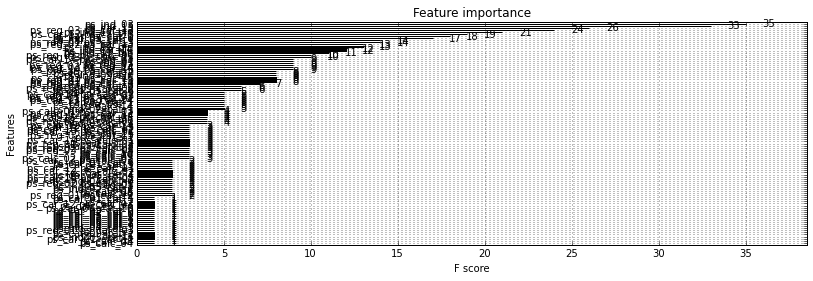

In [35]:
xgb.plot_importance(alg_after,height=0.1)

# 结论

模型及参数相同的情况下，增加特征工程后，对最终结果有正向效果。

特征工程之前： GINI Score (Train)为 0.289036

特征工程之后： GINI Score (Train)为 0.297813

不过，新训练集的训练效果和测试效果差别略大，需要调参数。

In [36]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

thresholds = - sort(- xgb2.feature_importances_)
print thresholds

[ 0.05718954  0.05392157  0.04248366  0.03921569  0.03431373  0.03104575
  0.02941176  0.02777778  0.02287582  0.02287582  0.02124183  0.02124183
  0.01960784  0.01960784  0.01797386  0.01633987  0.01633987  0.01470588
  0.01470588  0.01470588  0.01470588  0.01470588  0.01470588  0.0130719
  0.0130719   0.0130719   0.0130719   0.0130719   0.0130719   0.01143791
  0.00980392  0.00980392  0.00980392  0.00816994  0.00816994  0.00816994
  0.00816994  0.00816994  0.00816994  0.00816994  0.00816994  0.00816994
  0.00653595  0.00653595  0.00653595  0.00653595  0.00653595  0.00653595
  0.00653595  0.00490196  0.00490196  0.00490196  0.00490196  0.00490196
  0.00490196  0.00490196  0.00490196  0.00490196  0.00490196  0.00490196
  0.00490196  0.00490196  0.00490196  0.00490196  0.00490196  0.00490196
  0.00326797  0.00326797  0.00326797  0.00326797  0.00326797  0.00326797
  0.00326797  0.00326797  0.00326797  0.00326797  0.00326797  0.00326797
  0.00326797  0.00326797  0.00326797  0.00326797  0.

In [37]:
i=0
feature_new=[]
imp = xgb2.feature_importances_
while i < len(predictors2):
    print predictors2[i],":",imp[i]
    if imp[i]>0.004:
        feature_new.append(predictors2[i])
    i=i+1

ps_ind_01 : 0.0147059
ps_ind_03 : 0.0571895
ps_ind_06_bin : 0.0212418
ps_ind_07_bin : 0.0179739
ps_ind_08_bin : 0.00653595
ps_ind_09_bin : 0.0130719
ps_ind_10_bin : 0.0
ps_ind_11_bin : 0.0
ps_ind_12_bin : 0.0
ps_ind_13_bin : 0.0
ps_ind_14 : 0.0
ps_ind_15 : 0.0539216
ps_ind_16_bin : 0.0196078
ps_ind_17_bin : 0.0343137
ps_ind_18_bin : 0.0
ps_reg_01 : 0.00326797
ps_reg_02 : 0.0
ps_reg_03 : 0.0147059
ps_car_11 : 0.00326797
ps_car_12 : 0.00163399
ps_car_13 : 0.0424837
ps_car_14 : 0.0196078
ps_car_15 : 0.00490196
ps_calc_01 : 0.0
ps_calc_02 : 0.0
ps_calc_03 : 0.0
ps_calc_04 : 0.00163399
ps_calc_05 : 0.00326797
ps_calc_06 : 0.00326797
ps_calc_07 : 0.0
ps_calc_08 : 0.00163399
ps_calc_09 : 0.00490196
ps_calc_10 : 0.00490196
ps_calc_11 : 0.00163399
ps_calc_12 : 0.0
ps_calc_13 : 0.00490196
ps_calc_14 : 0.00816994
ps_calc_15_bin : 0.00163399
ps_calc_16_bin : 0.0
ps_calc_17_bin : 0.0
ps_calc_18_bin : 0.0
ps_calc_19_bin : 0.0
ps_calc_20_bin : 0.0
ps_car_11_cat_tm : 0.0130719
ps_ind_02_cat_1 : 0.0081

In [38]:
predictors2_new = [x for x in train_extends.columns if x in feature_new]
print len(predictors2_new)

xgb2_new = XGBClassifier(
        learning_rate =0.01,
        n_estimators=20,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=26.4, #解决样本不均衡的问题
        seed=27)

alg_after2=xgboostModelFit(xgb2_new, train_extends, validation_extends, predictors2_new)

66

Model Report- train data
Accuracy（Train） : 0.6246
AUC Score (Train): 0.630315
GINI Score (Train): 0.260661


/Library/Python/2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Model Report- test data
Accuracy（Test） : 0.6246
AUC Score (Test): 0.619978
GINI Score (Test): 0.240039


/Library/Python/2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# 以下是最终测试数据效果

## 特征工程之前

In [39]:
test1 = pd.read_csv("/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input/test.csv")


In [40]:
#最终测试集
test_raw= test1
X_test_raw= test1[predictors1]
y_raw_test_pred = alg_before.predict(X_test_raw)
y_raw_test_predprob=alg_before.predict_proba(X_test_raw)[:,1]

In [41]:
X_ID = test_raw['id']
X_ID=pd.DataFrame(X_ID)
df_y_test_predprob=pd.DataFrame(y_raw_test_predprob)
print df_y_test_predprob.shape,X_ID.shape

(892816, 1) (892816, 1)


In [42]:
result=pd.concat([X_ID,df_y_test_predprob],axis=1)
result.columns = ['id', 'target']
result.shape

(892816, 2)

In [43]:
result.to_csv("/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/test_result_old.csv",index=False)

## 特征工程之后

In [44]:
test2 = pd.read_csv("/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/input/test_extends.csv")

In [45]:
#最终测试集
test_raw= test2
print test_raw.columns
X_test_raw= test2[predictors2]
print X_test_raw.columns
y_raw_test_pred = alg_after.predict(X_test_raw)
y_raw_test_predprob=alg_after.predict_proba(X_test_raw)[:,1]

Index([u'id', u'tag', u'target', u'ps_ind_01', u'ps_ind_03', u'ps_ind_06_bin',
       u'ps_ind_07_bin', u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin',
       ...
       u'ps_car_15^2', u'ps_car_15 ps_calc_01', u'ps_car_15 ps_calc_02',
       u'ps_car_15 ps_calc_03', u'ps_calc_01^2', u'ps_calc_01 ps_calc_02',
       u'ps_calc_01 ps_calc_03', u'ps_calc_02^2', u'ps_calc_02 ps_calc_03',
       u'ps_calc_03^2'],
      dtype='object', length=179)
Index([u'ps_ind_01', u'ps_ind_03', u'ps_ind_06_bin', u'ps_ind_07_bin',
       u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin', u'ps_ind_11_bin',
       u'ps_ind_12_bin', u'ps_ind_13_bin',
       ...
       u'ps_car_15^2', u'ps_car_15 ps_calc_01', u'ps_car_15 ps_calc_02',
       u'ps_car_15 ps_calc_03', u'ps_calc_01^2', u'ps_calc_01 ps_calc_02',
       u'ps_calc_01 ps_calc_03', u'ps_calc_02^2', u'ps_calc_02 ps_calc_03',
       u'ps_calc_03^2'],
      dtype='object', length=176)


In [46]:
X_ID = test_raw['id']
X_ID=pd.DataFrame(X_ID)
df_y_test_predprob=pd.DataFrame(y_raw_test_predprob)
print df_y_test_predprob.shape,X_ID.shape


(892816, 1) (892816, 1)


In [47]:
result=pd.concat([X_ID,df_y_test_predprob],axis=1)
result.columns = ['id', 'target']
result.shape

(892816, 2)

In [48]:
result.to_csv("/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/test_result.csv",index=False)

# LB

**在leaderboard上，特征工程之前0.257，特征工程之后0.257。